# TFG

Primero importamos las librerías

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sea

Importamos los datos, e imprimimos los primeros para comprobar que se han importado correctamente.

In [41]:
df = pd.read_csv('BTC-Daily.csv')
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


In [42]:
df.tail()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
2646,1417478400,2014-12-02 00:00:00,BTC/USD,378.39,382.86,375.23,379.25,2593576.46,6832.53
2647,1417392000,2014-12-01 00:00:00,BTC/USD,376.40,382.31,373.03,378.39,2520662.37,6660.56
2648,1417305600,2014-11-30 00:00:00,BTC/USD,376.57,381.99,373.32,373.34,1145566.61,3046.33
2649,1417219200,2014-11-29 00:00:00,BTC/USD,376.42,386.60,372.25,376.72,2746157.05,7245.19
2650,1417132800,2014-11-28 00:00:00,BTC/USD,363.59,381.34,360.57,376.28,3220878.18,8617.15


Observamos el número de valores de cada columna y que no tengan ningún valor nulo

In [43]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unix        2651 non-null   int64  
 1   date        2651 non-null   object 
 2   symbol      2651 non-null   object 
 3   open        2651 non-null   float64
 4   high        2651 non-null   float64
 5   low         2651 non-null   float64
 6   close       2651 non-null   float64
 7   Volume BTC  2651 non-null   float64
 8   Volume USD  2651 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 186.5+ KB
None


Visulaizamos las estadísticas de los datos

In [44]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unix,2651.0,1.531613e+09,6.613247e+07,1.417133e+09,1.474373e+09,1.531613e+09,1.588853e+09,1.646093e+09
open,2651.0,1.169319e+04,1.627255e+04,1.620000e+02,6.546800e+02,6.408950e+03,1.070862e+04,6.754749e+04
high,2651.0,1.203856e+04,1.673924e+04,2.128400e+02,6.644600e+02,6.540000e+03,1.095624e+04,6.900000e+04
low,2651.0,1.129654e+04,1.571830e+04,1.524000e+02,6.400500e+02,6.312000e+03,1.030376e+04,6.625000e+04
close,2651.0,1.170933e+04,1.628291e+04,1.620000e+02,6.543700e+02,6.407770e+03,1.072642e+04,6.755900e+04
Volume BTC,2651.0,1.330041e+07,4.715366e+07,0.000000e+00,5.357883e+03,1.503310e+04,3.435336e+06,7.723295e+08
Volume USD,2651.0,6.099369e+07,1.072838e+08,0.000000e+00,9.516170e+03,2.288982e+07,8.018383e+07,1.446125e+09


Visulaizamos los precios de 'open' en un histograma

array([[<Axes: title={'center': 'open'}>]], dtype=object)

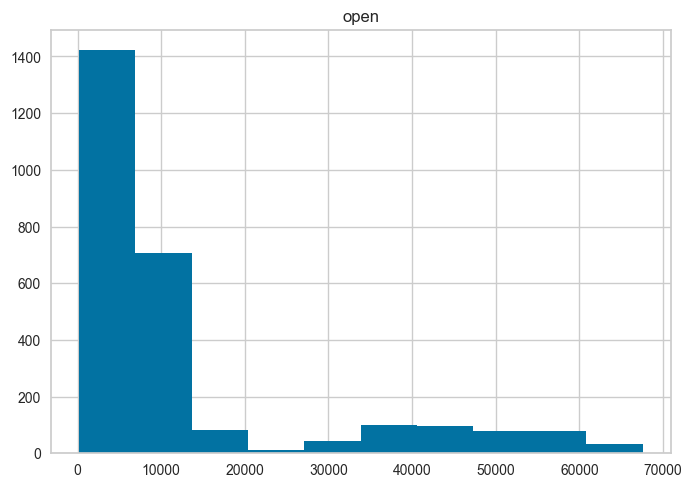

In [45]:
df.hist('open')

Eliminamos las columnas unix, symbol y Volume BTC que no van a ser útiles de cara al entrenamiento, esto lo hacemos en una copia de df que se llamará df_sn y es lo que utilizaremos a partir de ahora.

In [46]:
#df_sn = solo los datos necesarios para entrenar el algoritmo, con tiempo aún de reducirlos más
df_sn = df.copy().drop(['unix', 'symbol', 'Volume BTC'], axis = 1)
df_sn.sort_values(by='date')

,date,open,high,low,close,Volume USD
2650,2014-11-28 00:00:00,363.59,381.34,360.57,376.28,8.617150e+03
2649,2014-11-29 00:00:00,376.42,386.60,372.25,376.72,7.245190e+03
2648,2014-11-30 00:00:00,376.57,381.99,373.32,373.34,3.046330e+03
2647,2014-12-01 00:00:00,376.40,382.31,373.03,378.39,6.660560e+03
2646,2014-12-02 00:00:00,378.39,382.86,375.23,379.25,6.832530e+03
...,...,...,...,...,...,...
4,2022-02-25 00:00:00,38360.93,39727.97,38027.61,39231.64,8.642149e+07
3,2022-02-26 00:00:00,39242.64,40330.99,38600.00,39146.66,3.573010e+07
2,2022-02-27 00:00:00,39146.66,39886.92,37015.74,37712.68,6.418008e+07
1,2022-02-28 00:00:00,37717.10,44256.08,37468.99,43178.98,1.364723e+08


# Preprocesado de datos

Obtenemos en una variable la cantidad de filas 

In [47]:
tamanio = df_sn.shape[0]
tamanio

2651

Separamos el 10% de los datos con fecha más reciente para test

In [48]:
df_test = df_sn.copy().loc[0:int(tamanio*0.1)]
df_test

,date,open,high,low,close,Volume USD
0,2022-03-01 00:00:00,43221.71,43626.49,43185.48,43185.48,2.116360e+06
1,2022-02-28 00:00:00,37717.10,44256.08,37468.99,43178.98,1.364723e+08
2,2022-02-27 00:00:00,39146.66,39886.92,37015.74,37712.68,6.418008e+07
3,2022-02-26 00:00:00,39242.64,40330.99,38600.00,39146.66,3.573010e+07
4,2022-02-25 00:00:00,38360.93,39727.97,38027.61,39231.64,8.642149e+07
...,...,...,...,...,...,...
261,2021-06-13 00:00:00,35563.66,39386.43,34783.90,39013.76,1.405244e+08
262,2021-06-12 00:00:00,37338.91,37445.55,34630.00,35542.76,1.325017e+08
263,2021-06-11 00:00:00,36724.97,37680.65,35958.49,37341.11,1.397017e+08
264,2021-06-10 00:00:00,37414.64,38446.24,35824.69,36707.54,2.114987e+08


Separamos un 20% de los datos para validación

In [49]:
df_vali = df_sn.copy().loc[range(int(tamanio*0.1)+1, int(tamanio*0.3))]
df_vali

,date,open,high,low,close,Volume USD
266,2021-06-08 00:00:00,33567.51,34085.61,31025.00,33411.69,3.021970e+08
267,2021-06-07 00:00:00,35810.69,36808.30,33321.09,33582.62,1.649928e+08
268,2021-06-06 00:00:00,35532.59,36510.58,35250.00,35808.85,9.047943e+07
269,2021-06-05 00:00:00,36851.58,37927.93,34849.65,35532.14,1.459074e+08
270,2021-06-04 00:00:00,39242.94,39277.36,35576.67,36887.32,2.134369e+08
...,...,...,...,...,...,...
790,2020-01-01 00:00:00,7160.69,7237.35,7150.00,7178.68,8.033730e+06
791,2019-12-31 00:00:00,7222.74,7302.35,7112.55,7168.36,1.891509e+07
792,2019-12-30 00:00:00,7372.79,7384.90,7199.00,7220.24,2.688033e+07
793,2019-12-29 00:00:00,7297.43,7524.46,7274.43,7385.54,1.908314e+07


Separamos para entrenamiento el 70% de los datos, empezando por los que tienen la fecha inicial más temprana

In [50]:
df_train = df_sn.copy().loc[range(int(tamanio*0.3), tamanio)]
df_train

,date,open,high,low,close,Volume USD
795,2019-12-27 00:00:00,7195.17,7255.37,7052.00,7246.00,2.916204e+07
796,2019-12-26 00:00:00,7195.80,7432.00,7150.00,7188.30,2.240411e+07
797,2019-12-25 00:00:00,7247.45,7266.81,7110.73,7195.79,1.082626e+07
798,2019-12-24 00:00:00,7317.47,7431.10,7156.00,7251.52,3.041715e+07
799,2019-12-23 00:00:00,7521.88,7692.98,7247.86,7316.17,4.909711e+07
...,...,...,...,...,...,...
2646,2014-12-02 00:00:00,378.39,382.86,375.23,379.25,6.832530e+03
2647,2014-12-01 00:00:00,376.40,382.31,373.03,378.39,6.660560e+03
2648,2014-11-30 00:00:00,376.57,381.99,373.32,373.34,3.046330e+03
2649,2014-11-29 00:00:00,376.42,386.60,372.25,376.72,7.245190e+03


Indexamos el conjunto de test por 'date' y lo ordenamos.

In [51]:
#df_test = df_test.set_index('date')
df_test = df_test.sort_values(by='date')
df_test

,date,open,high,low,close,Volume USD
265,2021-06-09 00:00:00,33413.19,37556.25,32423.72,37400.00,3.193806e+08
264,2021-06-10 00:00:00,37414.64,38446.24,35824.69,36707.54,2.114987e+08
263,2021-06-11 00:00:00,36724.97,37680.65,35958.49,37341.11,1.397017e+08
262,2021-06-12 00:00:00,37338.91,37445.55,34630.00,35542.76,1.325017e+08
261,2021-06-13 00:00:00,35563.66,39386.43,34783.90,39013.76,1.405244e+08
...,...,...,...,...,...,...
4,2022-02-25 00:00:00,38360.93,39727.97,38027.61,39231.64,8.642149e+07
3,2022-02-26 00:00:00,39242.64,40330.99,38600.00,39146.66,3.573010e+07
2,2022-02-27 00:00:00,39146.66,39886.92,37015.74,37712.68,6.418008e+07
1,2022-02-28 00:00:00,37717.10,44256.08,37468.99,43178.98,1.364723e+08


Indexamos el conjunto de validación por 'date' y lo ordenamos.

In [52]:
#df_vali = df_vali.set_index('date')
df_vali = df_vali.sort_values(by='date')
df_vali

,date,open,high,low,close,Volume USD
794,2019-12-28 00:00:00,7247.70,7349.65,7231.00,7296.24,1.152589e+07
793,2019-12-29 00:00:00,7297.43,7524.46,7274.43,7385.54,1.908314e+07
792,2019-12-30 00:00:00,7372.79,7384.90,7199.00,7220.24,2.688033e+07
791,2019-12-31 00:00:00,7222.74,7302.35,7112.55,7168.36,1.891509e+07
790,2020-01-01 00:00:00,7160.69,7237.35,7150.00,7178.68,8.033730e+06
...,...,...,...,...,...,...
270,2021-06-04 00:00:00,39242.94,39277.36,35576.67,36887.32,2.134369e+08
269,2021-06-05 00:00:00,36851.58,37927.93,34849.65,35532.14,1.459074e+08
268,2021-06-06 00:00:00,35532.59,36510.58,35250.00,35808.85,9.047943e+07
267,2021-06-07 00:00:00,35810.69,36808.30,33321.09,33582.62,1.649928e+08


Indexamos el conjunto de entrenamiento por 'date' y lo ordenamos.

In [53]:
#df_train = df_train.set_index('date')
#df_train = df_train.sort_index()
df_train = df_train.sort_values(by='date')
df_train

,date,open,high,low,close,Volume USD
2650,2014-11-28 00:00:00,363.59,381.34,360.57,376.28,8.617150e+03
2649,2014-11-29 00:00:00,376.42,386.60,372.25,376.72,7.245190e+03
2648,2014-11-30 00:00:00,376.57,381.99,373.32,373.34,3.046330e+03
2647,2014-12-01 00:00:00,376.40,382.31,373.03,378.39,6.660560e+03
2646,2014-12-02 00:00:00,378.39,382.86,375.23,379.25,6.832530e+03
...,...,...,...,...,...,...
799,2019-12-23 00:00:00,7521.88,7692.98,7247.86,7316.17,4.909711e+07
798,2019-12-24 00:00:00,7317.47,7431.10,7156.00,7251.52,3.041715e+07
797,2019-12-25 00:00:00,7247.45,7266.81,7110.73,7195.79,1.082626e+07
796,2019-12-26 00:00:00,7195.80,7432.00,7150.00,7188.30,2.240411e+07


## Predicción con Pycaret

In [54]:
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment
from pycaret.time_series import TSForecastingExperiment

In [55]:
df_train = df_train.sort_values(by='date')

In [56]:

index = pd.DatetimeIndex(df_train['date'])
rng = pd.date_range(index[0], periods=1856)
data = df_train['close'].to_numpy()
df_series = pd.Series(data = data, index = rng)
df_series

2014-11-28     376.28
2014-11-29     376.72
2014-11-30     373.34
2014-12-01     378.39
2014-12-02     379.25
               ...   
2019-12-23    7316.17
2019-12-24    7251.52
2019-12-25    7195.79
2019-12-26    7188.30
2019-12-27    7246.00
Freq: D, Length: 1856, dtype: float64

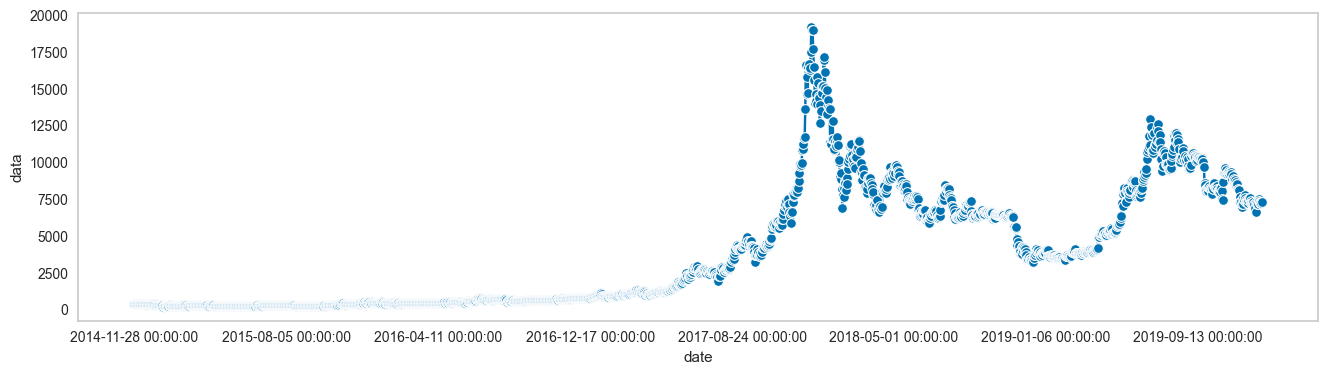

In [57]:
from sktime.utils.plotting import plot_series
_ = plot_series(df_series, x_label='date', y_label='data')
plt.grid()

In [58]:
from pycaret.time_series import TSForecastingExperiment


In [59]:
exp = TSForecastingExperiment()
exp.setup(data = df_series, fh=24, use_gpu = True)

,Description,Value
0,session_id,4484
1,Target,Time Series
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1856, 1)"
5,Transformed data shape,"(1856, 1)"
6,Transformed train set shape,"(1832, 1)"
7,Transformed test set shape,"(24, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no mo

In [60]:
best_baseline_models = exp.compare_models(n_select=5, sort='MAE')

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
polytrend,Polynomial Trend Forecaster,1.8286,1.0031,791.3686,900.6538,0.1005,0.0935,-2.2339,0.0133
arima,ARIMA,2.5729,1.3401,1107.6128,1201.4886,0.1368,0.1272,-8.7664,0.1400
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,2.6277,1.3878,1130.8435,1244.2673,0.1385,0.1298,-9.3026,0.3700
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,2.6278,1.3879,1130.9087,1244.3444,0.1386,0.1299,-9.3026,0.3800
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,2.6278,1.3879,1130.9087,1244.3444,0.1386,0.1299,-9.3026,0.3800
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,2.6279,1.3879,1130.9131,1244.3491,0.1386,0.1299,-9.3027,0.3633
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,2.6284,1.3882,1131.1330,1244.5939,0.1386,0.1299,-9.3082,0.3833
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,2.6284,1.3882,1131.1355,1244.5964,0.1386,0.1299,-9.3082,0.3767
exp_smooth,Exponential Smoothing,2.6562,1.3969,1142.5241,1252.3347,0.1389,0.1313,-9.6946,0.2000
auto_arima,Auto ARIMA,2.6596,1.4003,1144.5272,1255.5326,0.1397,0.1317,-9.3095,91.7467


In [61]:
best_baseline_modelsr = []
for i in range(0,5):
    if i != 1:
        best_baseline_modelsr.append(best_baseline_models[i])

In [62]:
best_tuned_models = [exp.tune_model(model) for model in best_baseline_modelsr]

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-09-22,1.4825,0.7371,631.3789,658.5225,0.0763,0.0736,-2.8799
1,2019-10-16,1.2237,0.7323,529.0682,658.2803,0.0639,0.0613,-0.0244
2,2019-11-09,2.7795,1.5401,1213.6585,1385.1585,0.1614,0.1457,-3.7974
Mean,NaT,1.8286,1.0031,791.3686,900.6538,0.1005,0.0935,-2.2339
SD,NaT,0.6807,0.3797,301.5112,342.5966,0.0433,0.0372,1.6066


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.7s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-09-22,3.9222,1.9073,1670.4213,1704.0300,0.2028,0.1833,-24.9800
1,2019-10-16,1.7562,0.9792,759.2849,880.2866,0.0838,0.0882,-0.8319
2,2019-11-09,2.2131,1.2801,966.3331,1151.2956,0.1294,0.1183,-2.3142
Mean,NaT,2.6305,1.3889,1132.0131,1245.2041,0.1387,0.1299,-9.3753
SD,NaT,0.9322,0.3866,389.9827,342.7851,0.0490,0.0397,11.0507


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-09-22,3.9222,1.9073,1670.3988,1704.0052,0.2028,0.1833,-24.9792
1,2019-10-16,1.7570,0.9797,759.6370,880.7100,0.0839,0.0882,-0.8336
2,2019-11-09,2.2128,1.2799,966.1988,1151.1278,0.1294,0.1183,-2.3133
Mean,NaT,2.6307,1.3889,1132.0782,1245.2810,0.1387,0.1299,-9.3754
SD,NaT,0.9320,0.3864,389.8793,342.6392,0.0490,0.0397,11.0501


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.4s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-09-22,3.9688,1.9314,1690.2515,1725.5758,0.2052,0.1853,-25.6411
1,2019-10-16,1.6958,0.9393,733.1633,844.3698,0.0813,0.0850,-0.6854
2,2019-11-09,2.2315,1.2736,974.3805,1145.4462,0.1302,0.1192,-2.2806
Mean,NaT,2.6320,1.3814,1132.5985,1238.4639,0.1389,0.1298,-9.5357
SD,NaT,0.9702,0.4121,406.4309,365.7141,0.0510,0.0416,11.4068


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.6s finished


In [63]:
best_tuned_models

[PolynomialTrendForecaster(),
 BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [10, 9,
                                                                         8, 7, 6,
                                                                         5, 4, 3,
                                                                         2, 1]},
                                                    n_jobs=1)],
                     regressor=BayesianRidge(), sp=10),
 BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [10, 9,
                                                                         8, 7, 6,
                                                                         5, 4, 3,
                                                                         2, 1]},
                                                    n_jobs=1)],
                     regressor=Ridge(random_state=4484), sp=10),
 BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag':

In [64]:
mean_blender = exp.blend_models(best_tuned_models, method='mean')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-09-22,3.2549,1.5971,1386.2313,1426.8604,0.1685,0.1547,-17.2157
1,2019-10-16,1.5300,0.8277,661.4935,744.0752,0.0741,0.0764,-0.3088
2,2019-11-09,2.3541,1.3475,1027.8899,1211.9401,0.1374,0.1252,-2.6726
Mean,NaT,2.3797,1.2574,1025.2049,1127.6252,0.1267,0.1188,-6.7324
SD,NaT,0.7044,0.3205,295.8791,285.0504,0.0393,0.0323,7.4754


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,EnsembleForecaster,1.6698,0.8612,736.3039,774.5317,0.1028,0.0972,-14.1175


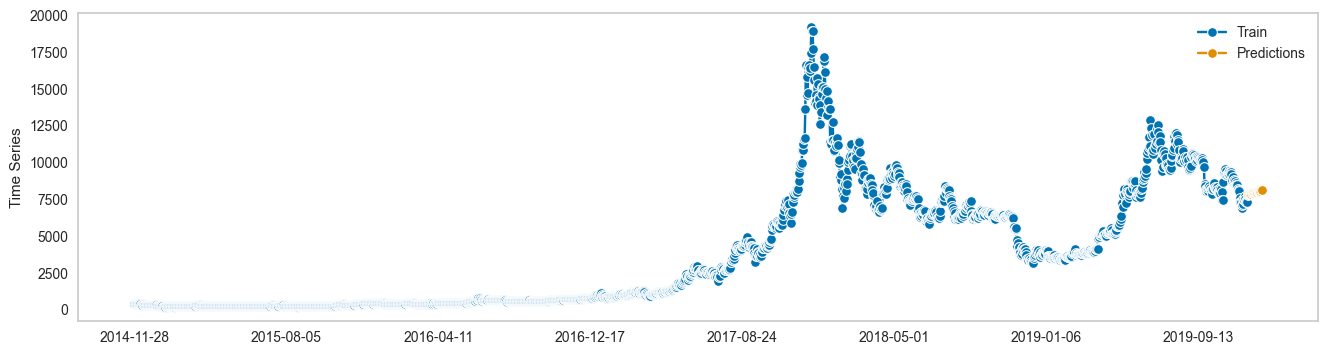

In [65]:
y_train = exp.get_config("y_train")
y_predict =exp.predict_model(mean_blender)
plot_series(y_train,y_predict,labels=['Train', 'Predictions'])
plt.grid()

# Predicción utilizando Machine Learning

### Utilizando RandomForestRegressor de la librería Scikit-learn.

Importando las librerías necesarias para la predicción

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

Preparamos los datos en las variables X e y para usarlos en el entrenamiento

In [67]:
X = []
y = []
for i in range(0, df_train.shape[0] - 25):
    auxy = df_train.iloc[i + 25]
    y.append(auxy.close)
    aux = []
    for r in range(0,25):
        aux.append(df_train.iloc[r].close)
    X.append(aux)
    

Declaramos el modelo

In [68]:
regr = RandomForestRegressor(max_depth=100, random_state=0)

Entrenamos el modelo

In [69]:
regr.fit(X, y)

RandomForestRegressor(max_depth=100, random_state=0)

Hacemos una predicción usando el conjunto de validación, para lo que previamente preparamos los datos

In [70]:
Vali = []
for i in range(0,25):
    Vali.append(df_vali.iloc[i].close)
print(df_vali.iloc[25].close)
Vali

8655.93


[7296.24,
 7385.54,
 7220.24,
 7168.36,
 7178.68,
 6950.56,
 7338.91,
 7344.48,
 7356.7,
 7762.74,
 8159.01,
 8044.44,
 7806.78,
 8200.0,
 8016.22,
 8180.76,
 8105.01,
 8813.04,
 8809.17,
 8710.15,
 8892.63,
 8908.53,
 8696.6,
 8625.17,
 8717.89]

In [71]:
print(regr.predict([Vali]))

[3906.15031038]


Segundo intento, esta vez utilizando todos los datos del día t, open, close, high y low, para predecir el close de t+1  

In [72]:
X1 = []
y1= []
for i in range(0, df_train.shape[0] - 1):
    auxy = df_train.iloc[i + 1]
    y1.append(auxy.close)
    aux = df_train.iloc[i]
    aux1 = []
    for r in range(1, aux.size):
        aux1.append(aux[r])
    X1.append(aux1)

In [73]:
regr1 = RandomForestRegressor(max_depth=100, random_state=0)

In [74]:
regr1.fit(X1, y1)

RandomForestRegressor(max_depth=100, random_state=0)

In [75]:
Vali1 = []
aux = df_vali.iloc[0]
for r in range (0,100):
    aux = df_vali.iloc[r]
    Vali1aux = []
    for i in range(1, aux.size):
        Vali1aux.append(aux[i])
    Vali1.append(Vali1aux)
predict = regr1.predict(Vali1)
print(predict)

[ 7209.8136  7373.4796  7273.8017  7288.2041  7220.952   7139.6944
  7115.0329  7050.7831  7477.9403  7890.7406  7982.3957  7993.9213
  7969.5031  8114.593   8052.0072  8289.5666  7987.1884  8798.2374
  8782.5793  8677.3606  8821.936   9048.96    8793.2553  8402.0004
  8479.2563  8453.5509  8256.5401  8174.0781  8266.6211  8528.4295
  8800.4288  9295.5314  9309.9709  9645.4593  9318.1451  9391.334
  9245.0047  9392.898   9140.2752  9468.3597  9844.9338  9834.9649
  9833.6632 10082.5065  9748.9391 10432.1318 10248.6547 10345.7559
 10274.9069  9751.3283  9522.8998  9577.8373 10406.7759  9491.8508
  9699.9794  9877.2735  9572.9537 10088.0259  9278.4027  9390.3307
  8921.5441  8805.1037  8663.6608  8469.3545  8462.6538  8709.0148
  8744.18    8660.4296  8983.9653  9138.7842  9086.8154  7866.639
  7829.4754  8103.9459  7756.0375  6124.3142  5019.064   5146.0846
  5267.7673  4747.4338  5118.4369  5276.74    6324.1896  6330.2886
  6264.301   6161.3305  6631.531   6845.8785  6791.8906  6730.76

Representamos la predicción y el valor real gráficamente

In [76]:
import matplotlib.pyplot as plt

In [77]:
Valirpr = []
for i in range(0,100):
    Valirpr.append(df_vali.iloc[i].close)

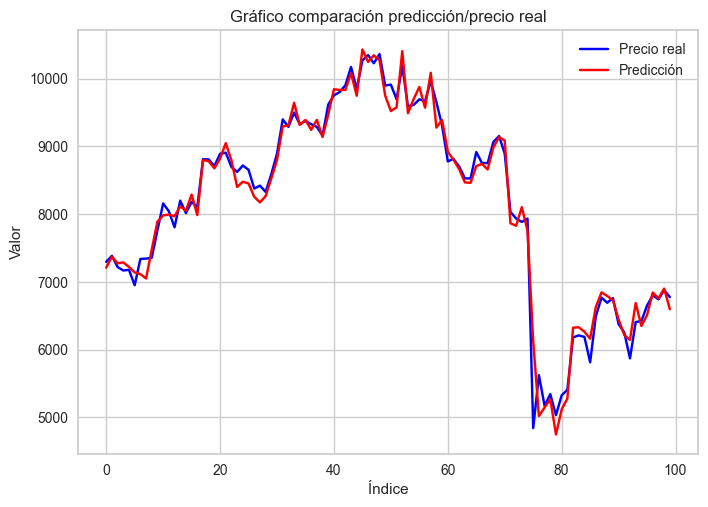

In [78]:
plt.plot(Valirpr, color='blue', label='Precio real')  # Línea azul
plt.plot(predict, color='red', label='Predicción')   # Línea roja
plt.title('Gráfico comparación predicción/precio real')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend() 

plt.show()